RQ2: Analysis of Masking Effect

1. merge the data

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

bg = pd.read_csv("../data/RQ2/background_traffic_full.csv")
bg.head()

,category,device,pps_idle,pps_var_idle,size_mean_idle,size_var_idle,proto_tls_idle,proto_tcp_idle,proto_udp_idle,proto_mdns_idle,...,num_flows_active,mean_pkts_per_flow_active,top_flow_frac_active,flow_entropy_active,num_dst_ips_active,num_dst_ports_active,iat_mean_active,iat_var_active,bts_idle,bts_active
0,tv,appletv,0.281912,82.535574,496.079125,210755.020710,0.025253,0.0,0.0,0.606061,...,71,16.718310,0.050548,4.087836,13,48,1.978185,239.924194,459.362538,469.527506
1,tv,LGtv,2.629911,110.070541,163.345556,34789.592431,0.080159,0.0,0.0,0.005079,...,2114,635.932829,0.666232,1.140080,55,1016,0.001784,0.001394,189.149595,1199.143932
2,tv,samsungtv,11.953214,16446.445547,1021.043294,412940.164006,0.948878,0.0,0.0,0.021106,...,125,3214.056000,0.621634,1.373712,36,310,0.005974,0.008283,654.557419,727.133481
3,tv,samsungtvsmall,2.483299,31.149502,220.900588,65092.311244,0.168262,0.0,0.0,0.000672,...,232,1496.297414,0.652781,1.060087,78,435,0.006913,0.005835,257.615248,755.776461
4,tv,tclroku,0.661172,87.170887,333.181761,178264.241340,0.276124,0.0,0.0,0.368588,...,223,1234.605381,0.777700,1.052752,68,617,0.008693,0.032916,422.874674,578.587092


In [20]:
import pandas as pd
import numpy as np

# load raw performance table
perf_raw = pd.read_csv("../data/RQ2/f1res.csv")

# remove trailing empty columns (your CSV has extra commas)
perf = perf_raw.loc[:, ~perf_raw.columns.str.contains("^Unnamed")]


# remove % signs and convert to float
for col in perf.columns:
    if perf[col].dtype == object:
        perf[col] = perf[col].str.replace("%", "", regex=False)

# convert all to numeric when possible
for col in perf.columns:
    perf[col] = pd.to_numeric(perf[col], errors="ignore")

perf.head()


,device,f1_idle,f1_active,Difference
0,samsungtvsmall,77.84,81.25,-3.41
1,google1d15,90.91,67.61,23.30
2,toshiba,92.05,69.32,22.73
3,echodot5,82.39,63.64,18.75
4,echodot3,92.42,75.57,16.86


2. Clustering

In [21]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

Reduced dimensions from 30 to 8
Running clustering...


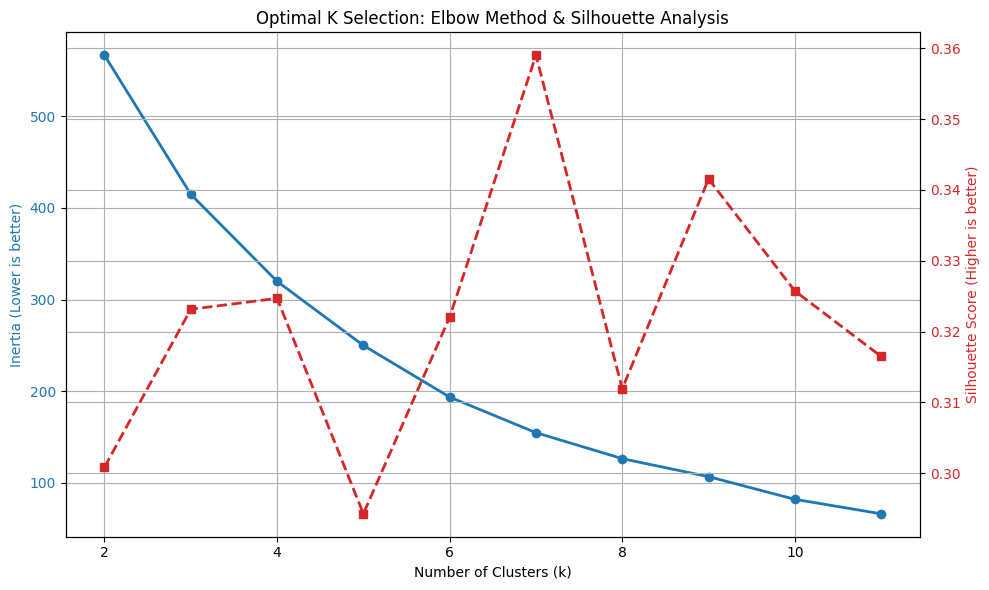

In [22]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# ---------------------------------------------------------
# 1. Load Data
# ---------------------------------------------------------
df = pd.read_csv("../data/RQ2/background_traffic_full.csv")

# Select only the feature columns (exclude labels)

feature_cols = [
    'pps_idle', 'pps_active', 'pps_var_idle', 'pps_var_active', 
    'size_mean_idle', 'size_mean_active', 'size_var_idle', 'size_var_active', 
    'proto_tls_idle', 'proto_tls_active', 'proto_tcp_idle', 'proto_tcp_active', 
    'proto_udp_idle', 'proto_udp_active', 'proto_mdns_idle', 'proto_mdns_active', 
    'proto_ssdp_idle', 'proto_ssdp_active', 'proto_arp_idle', 'proto_arp_active', 
    'proto_dhcp_idle', 'proto_dhcp_active', 'proto_other_idle', 'proto_other_active', 
    'inout_ratio_idle', 'inout_ratio_active', 'num_packets_idle', 'num_packets_active', 
    'bts_idle', 'bts_active'
]
'''
feature_cols = [
    # --- Volume & Variance ---
    'pps_idle', 'pps_active', 
    'pps_var_idle', 'pps_var_active',
    'num_packets_idle', 'num_packets_active',
    'burst_count_idle', 'burst_count_active',  # NEW

    # --- Packet Size Dynamics ---
    'size_mean_idle', 'size_mean_active', 
    'size_var_idle', 'size_var_active',
    'size_kurt_idle', 'size_kurt_active',      # NEW

    # --- Timing / Inter-arrival ---
    'iat_mean_idle', 'iat_mean_active',        # NEW
    'iat_var_idle', 'iat_var_active',          # NEW

    # --- Protocol Distribution ---
    'proto_tls_idle', 'proto_tls_active', 
    'proto_tcp_idle', 'proto_tcp_active', 
    'proto_udp_idle', 'proto_udp_active', 
    'proto_mdns_idle', 'proto_mdns_active', 
    'proto_ssdp_idle', 'proto_ssdp_active', 
    'proto_arp_idle', 'proto_arp_active', 
    'proto_dhcp_idle', 'proto_dhcp_active', 
    'proto_other_idle', 'proto_other_active', 

    # --- Flow / Endpoint Structure (NEW) ---
    'num_flows_idle', 'num_flows_active',
    'mean_pkts_per_flow_idle', 'mean_pkts_per_flow_active',
    'top_flow_frac_idle', 'top_flow_frac_active',
    'flow_entropy_idle', 'flow_entropy_active',
    'num_dst_ips_idle', 'num_dst_ips_active',
    'num_dst_ports_idle', 'num_dst_ports_active',

    # --- Traffic Direction & Strength ---
    'inout_ratio_idle', 'inout_ratio_active', 
    'bts_idle', 'bts_active'
]
'''

idle_features  = [f for f in feature_cols if f.endswith("_idle")]
active_features = [f for f in feature_cols if f.endswith("_active")]



X = df[feature_cols].copy()

# Clean: Convert to numeric and fill NaN with 0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# ---------------------------------------------------------
# 2. Preprocessing & PCA
# ---------------------------------------------------------
# Scale features (Critical for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce noise and correlation
# We keep 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"Reduced dimensions from {X.shape[1]} to {X_pca.shape[1]}")

# ---------------------------------------------------------
# 3. The Elbow Method Loop
# ---------------------------------------------------------
inertias = []
sil_scores = []
K_range = range(2, 12)  # Testing 2 to 11 clusters

print("Running clustering...")
for k in K_range:
    # n_init=10 ensures we don't get stuck in a bad local minimum
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_pca)
    
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_pca, km.labels_))

# ---------------------------------------------------------
# 4. Visualization
# ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Inertia (Elbow)
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Lower is better)', color=color)
ax1.plot(K_range, inertias, marker='o', color=color, linewidth=2, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Plot Silhouette (Score)
ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Silhouette Score (Higher is better)', color=color)
ax2.plot(K_range, sil_scores, marker='s', linestyle='--', color=color, linewidth=2, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Optimal K Selection: Elbow Method & Silhouette Analysis')
plt.tight_layout()
plt.savefig('elbow_analysis_RQ2.png')
plt.show()

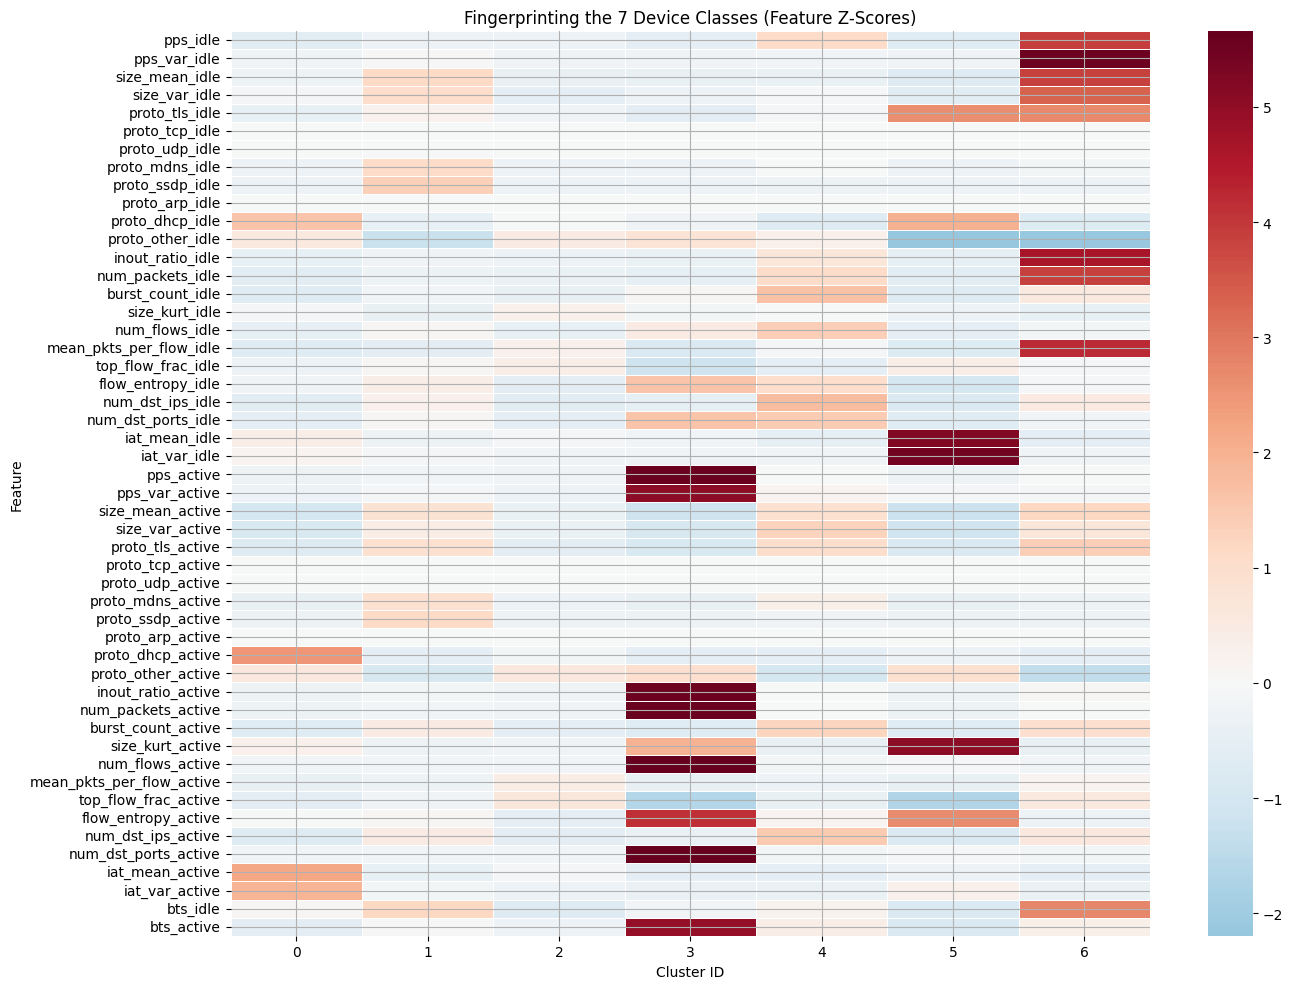

devices in each cluster:

--- Cluster 0 ---
['honeywell', 'levoit', 'swan', 'wiz']

--- Cluster 1 ---
['appletv', 'tclroku', 'toshiba', 'bose', 'homepod', 'sonos']

--- Cluster 2 ---
['cosori', 'weekett', 'xiaomiblender', 'echodot3', 'bluram6da9', 'boifun80c0', 'google1d15', 'hualai', 'yibefb', 'antela', 'fitop', 'lepro', 'lifx', 'yeelight4']

--- Cluster 3 ---
['amcrest266e']

--- Cluster 4 ---
['LGtv', 'samsungtvsmall', 'echodot5', 'echospot', 'googlehome', 'nestmini2']

--- Cluster 5 ---
['tapo']

--- Cluster 6 ---
['samsungtv']

--- Cluster 7 ---
[]


In [5]:
# =========================================================
# Final Clustering & Profiling (K=7)
# =========================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Setup (Same as before)
df = pd.read_csv("../data/RQ2/background_traffic_full.csv")

# Exclude non-numeric for calculation
feature_cols = [c for c in df.columns if c not in ["device", "category"]]
X = df[feature_cols].copy()
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# 2. Scale & PCA (Re-running to be safe)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95) # Preserving 95% variance
X_pca = pca.fit_transform(X_scaled)

# ---------------------------------------------------------
# 3. The Final Model (K=7)
# ---------------------------------------------------------
km_final = KMeans(n_clusters=7, n_init=20, random_state=42) # n_init=50 for stability
labels = km_final.fit_predict(X_pca)

# Add labels back to original DF for the paper's table
df["cluster_id"] = labels

# ---------------------------------------------------------
# 4. The Interpretation Heatmap
# ---------------------------------------------------------
# We map the clusters back to the SCALED features to compare them.
# (Scaled is better for heatmaps so 'bytes' don't drown out 'ratios')

X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
X_scaled_df["cluster_id"] = labels

# Group by cluster and calculate the average feature value
cluster_profiles = X_scaled_df.groupby("cluster_id").mean()

# Plot
plt.figure(figsize=(14, 10))
sns.heatmap(cluster_profiles.T, cmap="RdBu_r", center=0, linewidths=0.5, annot=False)

plt.title("Fingerprinting the 7 Device Classes (Feature Z-Scores)")
plt.xlabel("Cluster ID")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 5. Peek at the members
# ---------------------------------------------------------
print("devices in each cluster:")
for i in range(8):
    print(f"\n--- Cluster {i} ---")
    print(df[df["cluster_id"] == i]["device"].to_list())

In [6]:
df = pd.merge(df, perf, on="device", how="inner")
df.columns

Index(['category', 'device', 'pps_idle', 'pps_var_idle', 'size_mean_idle',
       'size_var_idle', 'proto_tls_idle', 'proto_tcp_idle', 'proto_udp_idle',
       'proto_mdns_idle', 'proto_ssdp_idle', 'proto_arp_idle',
       'proto_dhcp_idle', 'proto_other_idle', 'inout_ratio_idle',
       'num_packets_idle', 'burst_count_idle', 'size_kurt_idle',
       'num_flows_idle', 'mean_pkts_per_flow_idle', 'top_flow_frac_idle',
       'flow_entropy_idle', 'num_dst_ips_idle', 'num_dst_ports_idle',
       'iat_mean_idle', 'iat_var_idle', 'pps_active', 'pps_var_active',
       'size_mean_active', 'size_var_active', 'proto_tls_active',
       'proto_tcp_active', 'proto_udp_active', 'proto_mdns_active',
       'proto_ssdp_active', 'proto_arp_active', 'proto_dhcp_active',
       'proto_other_active', 'inout_ratio_active', 'num_packets_active',
       'burst_count_active', 'size_kurt_active', 'num_flows_active',
       'mean_pkts_per_flow_active', 'top_flow_frac_active',
       'flow_entropy_active', 'n

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# =========================================================
# 0. Setup: Map Cluster IDs to Your New Names
# =========================================================
# Ensure we have the 'Difference' column calculated
# (If you haven't calculated it yet: Difference = Idle F1 - Active F1)
if 'Difference' not in df.columns:
    df['Difference'] = df['f1_idle'] - df['f1_active']


# Define the mapping based on our Final Taxonomy
'''
cluster_map = {
    0: "0: Low-Intensity Cloud",
    1: "1: Silent / On-Demand",
    2: "2: High-Variance Streamer",
    3: "3: UDP Keep-Alive IoT",
    4: "4: Asymmetric Standby",
    5: "5: mDNS Media Agents",
    6: "6: UPnP/SSDP Intensive"
}
'''

cluster_map = {
    0: "C0",
    1: "C1",
    2: "C2",
    3: "C3",
    4: "C4",
    5: "C5",
    6: "C6",
    7: "C7"
}

# Apply mapping to create a readable column for plotting
df['cluster_name'] = df['cluster_id'].map(cluster_map)

# Define the order for the plot (0 to 6)
order = [cluster_map[i] for i in range(7)]

# =========================================================
# 1. Generate the Statistics Table
# =========================================================
summary_table = df.groupby('cluster_name').agg({
    'device': 'count',              # Number of devices in this cluster
    'f1_idle': ['mean', 'std'],     # Baseline Performance
    'f1_active': ['mean', 'std'],   # Masked Performance
    'Difference': 'mean'           # The Drop (Masking Severity)
           # The Traffic Volume
}).reset_index()

# Flatten columns
summary_table.columns = [
    'Cluster Profile', 'N', 
    'Idle F1 Mean', 'Idle F1 Std', 
    'Active F1 Mean', 'Active F1 Std', 
    'Avg F1 Drop'
]

print("=== RQ2/RQ3 PERFORMANCE IMPACT BY BEHAVIORAL CLUSTER ===")
print(summary_table.round(2))


=== RQ2/RQ3 PERFORMANCE IMPACT BY BEHAVIORAL CLUSTER ===
  Cluster Profile   N  Idle F1 Mean  Idle F1 Std  Active F1 Mean  \
0              C0   4         94.74         2.68           93.04   
1              C1   6         89.26         7.72           71.94   
2              C2  14         92.64         3.08           84.42   
3              C3   1         78.98          NaN           72.73   
4              C4   6         86.84         6.85           75.47   
5              C5   1         90.91          NaN           95.45   
6              C6   1         70.45          NaN           69.32   

   Active F1 Std  Avg F1 Drop  
0           1.88         1.70  
1           4.66        17.32  
2           9.62         8.23  
3            NaN         6.25  
4           9.09        11.36  
5            NaN        -4.55  
6            NaN         1.14  


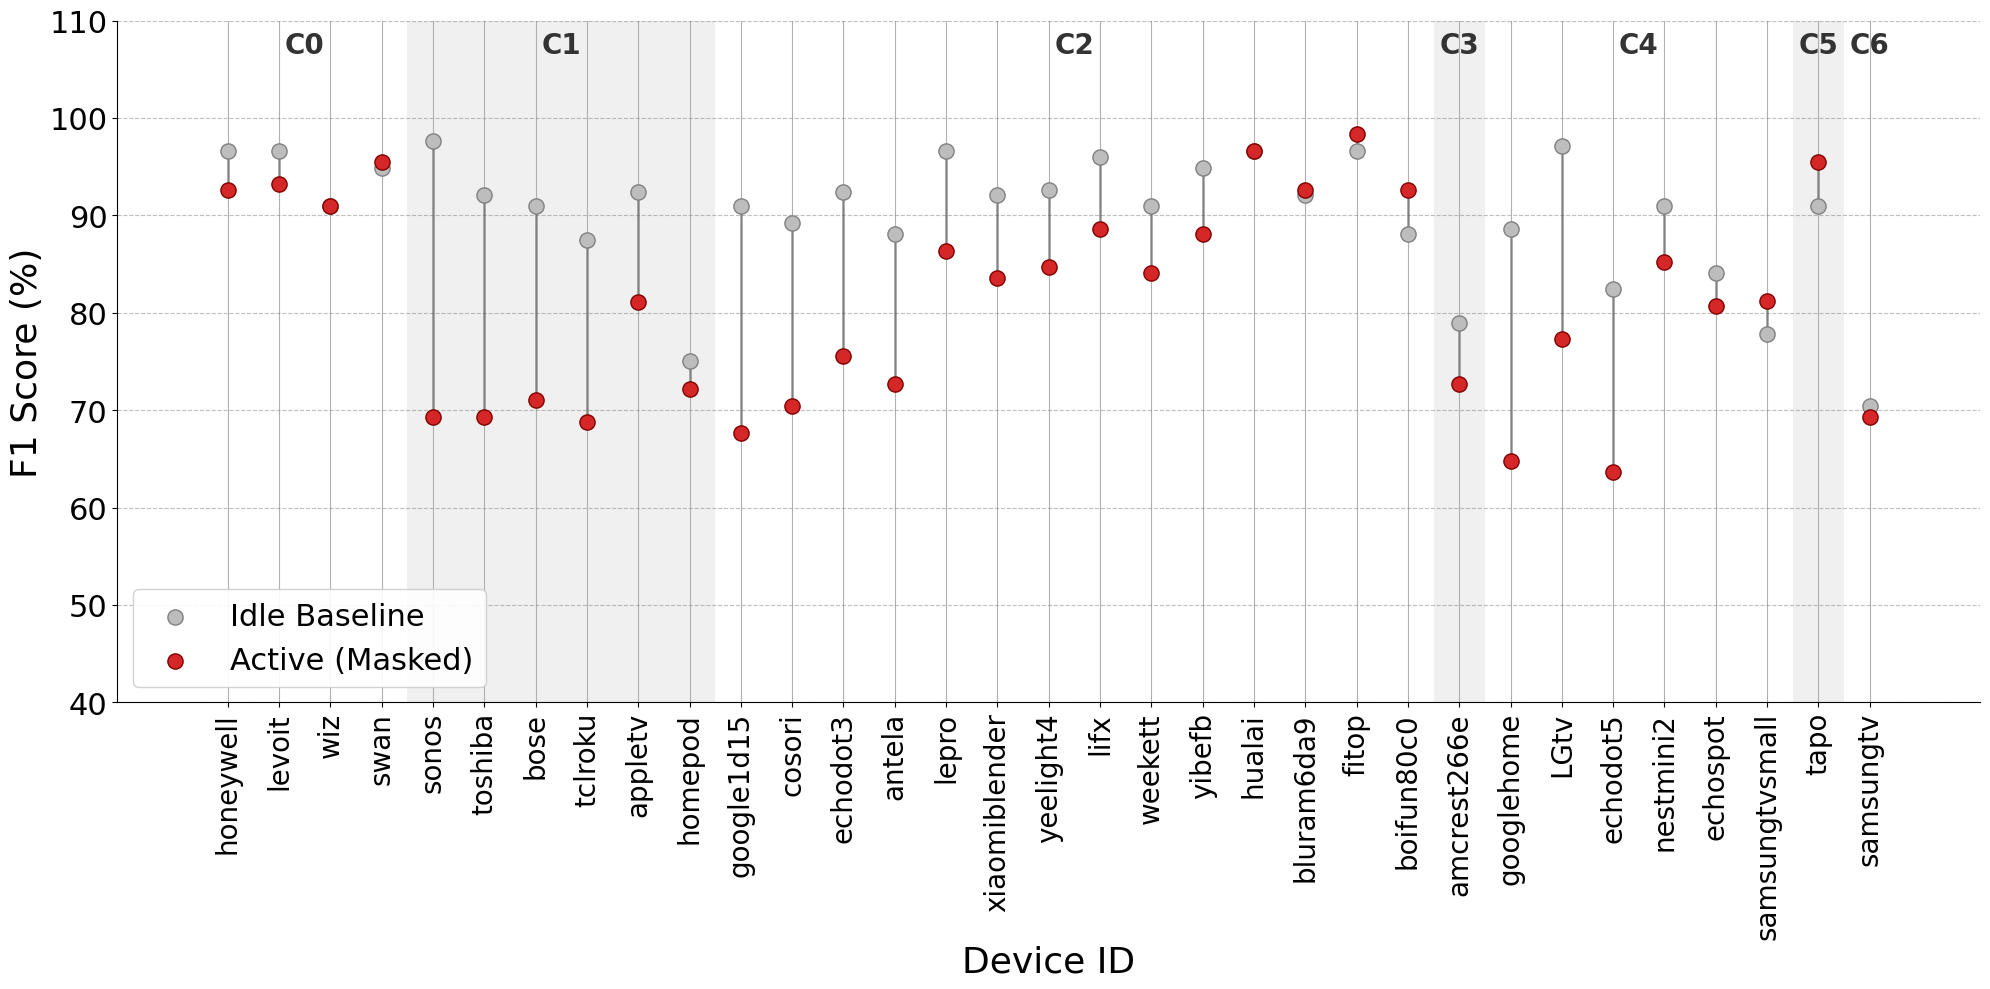

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# =========================================================
# 1. Data Preparation
# =========================================================

# Ensure 'Difference' column exists
if 'Difference' not in df.columns:
    df['Difference'] = df['f1_idle'] - df['f1_active']

# Map Cluster IDs to Short Names for the top labels
# (Short names prevent overcrowding on the plot)
cluster_map_short = {
    0: "C0",
    1: "C1",
    2: "C2",
    3: "C3",
    4: "C4",
    5: "C5",
    6: "C6",
    7: "C7"
}
df['Cluster_Label'] = df['cluster_id'].map(cluster_map_short)

# Sorting Strategy:
# 1. By Cluster ID (to keep groups together)
# 2. By Difference (Gap) Descending (to show the worst cases first within each group)
df_sorted = df.sort_values(by=['cluster_id', 'Difference'], ascending=[True, False]).reset_index(drop=True)

# Extract data for plotting
devices = df_sorted['device'].values
x_pos = np.arange(len(devices))
y_idle = df_sorted['f1_idle'].values
y_active = df_sorted['f1_active'].values

# =========================================================
# 2. Plotting Setup
# =========================================================
# Increased width to accommodate the large font sizes and many devices
fig, ax = plt.subplots(figsize=(20, 10)) 

# Colors
color_idle = "#bdbdbd"      # Light Grey (Baseline)
color_active = "#d62728"    # Deep Red (Masked - highlights the drop)
color_line = "#525252"      # Dark Grey for the connecting line

# =========================================================
# 3. Draw Background Shading (Cluster Zones)
# =========================================================
# We iterate through the grouped dataframe to find start/end indices for each cluster
cluster_groups = df_sorted.groupby('cluster_id')

# Two very light alternating colors for the background zones
bg_colors = ['#ffffff', '#f0f0f0'] 

for i, (cluster_id, group) in enumerate(cluster_groups):
    indices = group.index
    start = indices[0] - 0.5
    end = indices[-1] + 0.5
    
    # Draw the shaded rectangle
    ax.axvspan(start, end, facecolor=bg_colors[i % 2], alpha=1.0, zorder=0)
    
    # Add Cluster Label at the top
    mid_point = (start + end) / 2
    label_text = cluster_map_short.get(cluster_id, str(cluster_id))
    ax.text(mid_point, 106, label_text, ha='center', va='bottom', 
            fontsize=20, fontweight='bold', color='#333333')

# =========================================================
# 4. Draw Dumbbell Plot
# =========================================================

# A. Vertical Lines (The Gap)
# We plot these one by one or via vlines. vlines is cleaner.
ax.vlines(x=x_pos, ymin=y_active, ymax=y_idle, color=color_line, alpha=0.5, linewidth=2, zorder=1)

# B. Points (Idle & Active)
# Idle Points (Baseline)
ax.scatter(x_pos, y_idle, s=120, color=color_idle, label='Idle Baseline', zorder=2, edgecolors='grey')

# Active Points (Masked)
ax.scatter(x_pos, y_active, s=120, color=color_active, label='Active (Masked)', zorder=3, edgecolors='maroon')

# =========================================================
# 5. Styling & Formatting (Using your requested sizes)
# =========================================================

# Y-Axis Range and Grid
ax.set_ylim(40, 110) # Leave space at top for labels
ax.grid(axis='y', linestyle='--', alpha=0.5, color='grey')
ax.set_axisbelow(True) # Ensure grid is behind the plot

# Labels
ax.set_ylabel("F1 Score (%)", fontsize=26)
ax.set_xlabel("Device ID", fontsize=26)

# Ticks
ax.set_xticks(x_pos)
ax.set_xticklabels(devices, rotation=90, fontsize=20) # Slightly smaller than 22 to fit names
ax.tick_params(axis='y', labelsize=22)

# Legend
# Create a custom legend with a frame
ax.legend(loc='lower left', fontsize=22, frameon=True, framealpha=0.9, title_fontsize=22)

# Clean Spines (Remove top and right borders for a cleaner look)
sns.despine()

# Final Layout Adjustment
plt.tight_layout()

# Save
plt.savefig("../data/RQ2/rq2_per_device_dumbbell.pdf", dpi=300)
plt.show()

In [9]:
bg = pd.read_csv("../data/RQ2/background_traffic_full.csv")
bg.head()

,category,device,pps_idle,pps_var_idle,size_mean_idle,size_var_idle,proto_tls_idle,proto_tcp_idle,proto_udp_idle,proto_mdns_idle,...,num_flows_active,mean_pkts_per_flow_active,top_flow_frac_active,flow_entropy_active,num_dst_ips_active,num_dst_ports_active,iat_mean_active,iat_var_active,bts_idle,bts_active
0,tv,appletv,0.281912,82.535574,496.079125,210755.020710,0.025253,0.0,0.0,0.606061,...,71,16.718310,0.050548,4.087836,13,48,1.978185,239.924194,459.362538,469.527506
1,tv,LGtv,2.629911,110.070541,163.345556,34789.592431,0.080159,0.0,0.0,0.005079,...,2114,635.932829,0.666232,1.140080,55,1016,0.001784,0.001394,189.149595,1199.143932
2,tv,samsungtv,11.953214,16446.445547,1021.043294,412940.164006,0.948878,0.0,0.0,0.021106,...,125,3214.056000,0.621634,1.373712,36,310,0.005974,0.008283,654.557419,727.133481
3,tv,samsungtvsmall,2.483299,31.149502,220.900588,65092.311244,0.168262,0.0,0.0,0.000672,...,232,1496.297414,0.652781,1.060087,78,435,0.006913,0.005835,257.615248,755.776461
4,tv,tclroku,0.661172,87.170887,333.181761,178264.241340,0.276124,0.0,0.0,0.368588,...,223,1234.605381,0.777700,1.052752,68,617,0.008693,0.032916,422.874674,578.587092


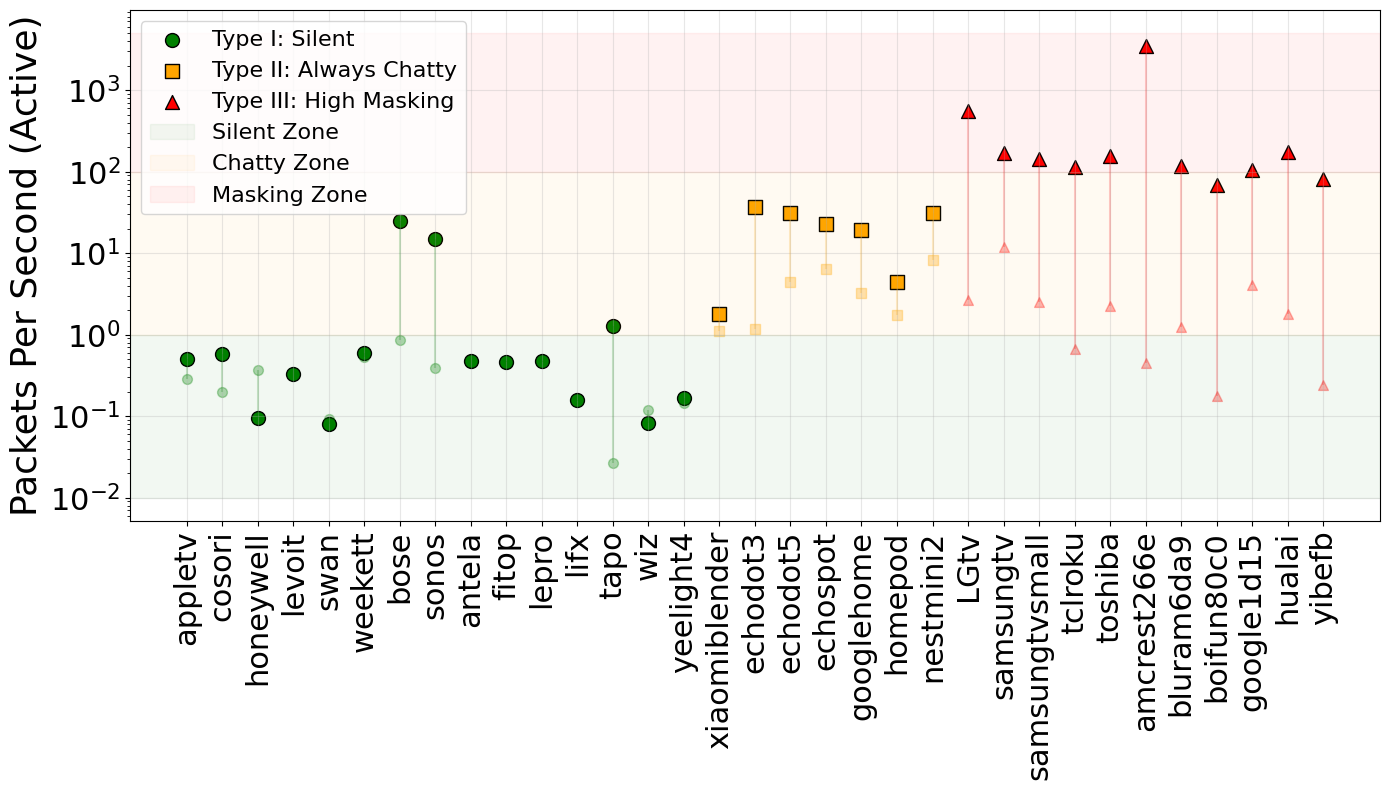

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np

# 1. Define the Classification Function
def categorize_device(row):
    idle = row['pps_idle']
    active = row['pps_active']
    
    # Priority 1: High Masking (The "Burst" Group)
    # If active traffic is huge (>50 PPS) AND it's a big jump from idle
    if active > 50:
        return "Type III: High Masking"
    
    # Priority 2: Chatty Baseline (The "Noisy" Group)
    # If it never shuts up (Idle > 2 PPS)
    elif idle > 1:
        return "Type II: Always Chatty"
    
    # Priority 3: Silent (The "Clean" Group)
    else:
        return "Type I: Silent"

# Apply the category
bg['category_label'] = bg.apply(categorize_device, axis=1)

# -------------------------------------------------------
# 2. Plot with Regions
# -------------------------------------------------------
plt.figure(figsize=(14, 8))

# Define colors for categories
colors = {'Type I: Silent': 'green', 'Type II: Always Chatty': 'orange', 'Type III: High Masking': 'red'}
markers = {'Type I: Silent': 'o', 'Type II: Always Chatty': 's', 'Type III: High Masking': '^'}

# Plot each category separately for the legend
for cat, group_data in bg.groupby('category_label'):
    # We plot the ACTIVE PPS as the main indicator of difficulty
    plt.scatter(group_data['device'], group_data['pps_active'], 
                c=colors[cat], label=cat, s=100, marker=markers[cat], edgecolors='black')
    
    # Add the "Ghost" dot for Idle to show the gap
    plt.scatter(group_data['device'], group_data['pps_idle'], 
                c=colors[cat], alpha=0.3, s=50, marker=markers[cat])
    
    # Draw the vertical lines for the gap
    plt.vlines(x=group_data['device'], ymin=group_data['pps_idle'], ymax=group_data['pps_active'], 
               color=colors[cat], alpha=0.2)

# -------------------------------------------------------
# 3. Add Background "Zones" (The Quantitative Thresholds)
# -------------------------------------------------------
# You can draw horizontal bands to show the threshold levels visually
# Zone 1: Silent (< 10 PPS)
plt.axhspan(0.01, 1, color='green', alpha=0.05, label='Silent Zone')
# Zone 2: Moderate/Chatty (10 - 100 PPS)
plt.axhspan(1, 100, color='orange', alpha=0.05, label='Chatty Zone')
# Zone 3: Masking (> 100 PPS)
plt.axhspan(100, 5000, color='red', alpha=0.05, label='Masking Zone')

# Formatting
plt.yscale("log")
plt.xticks(rotation=90, fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel("Packets Per Second (Active)", fontsize=26)
# plt.title("Device Classification based on Traffic Intensity", fontsize=24)
plt.legend(loc="upper left", fontsize = 16)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig("../data/RQ2/pps.pdf")
plt.show()

In [11]:
import pandas as pd
import numpy as np

# load raw performance table
perf_raw = pd.read_csv("../data/RQ2/f1res.csv")

# remove trailing empty columns (your CSV has extra commas)
perf = perf_raw.loc[:, ~perf_raw.columns.str.contains("^Unnamed")]

# rename device column to match bg table
perf = perf.rename(columns={"devices": "device"})

# remove % signs and convert to float
for col in perf.columns:
    if perf[col].dtype == object:
        perf[col] = perf[col].str.replace("%", "", regex=False)

# convert all to numeric when possible
for col in perf.columns:
    perf[col] = pd.to_numeric(perf[col], errors="ignore")

perf.head()


,device,f1_idle,f1_active,Difference
0,samsungtvsmall,77.84,81.25,-3.41
1,google1d15,90.91,67.61,23.30
2,toshiba,92.05,69.32,22.73
3,echodot5,82.39,63.64,18.75
4,echodot3,92.42,75.57,16.86


In [12]:
df = pd.merge(bg, perf, on="device", how="inner")

In [13]:
df.head()

,category,device,pps_idle,pps_var_idle,size_mean_idle,size_var_idle,proto_tls_idle,proto_tcp_idle,proto_udp_idle,proto_mdns_idle,...,num_dst_ips_active,num_dst_ports_active,iat_mean_active,iat_var_active,bts_idle,bts_active,category_label,f1_idle,f1_active,Difference
0,tv,appletv,0.281912,82.535574,496.079125,210755.020710,0.025253,0.0,0.0,0.606061,...,13,48,1.978185,239.924194,459.362538,469.527506,Type I: Silent,92.44,81.09,11.35
1,tv,LGtv,2.629911,110.070541,163.345556,34789.592431,0.080159,0.0,0.0,0.005079,...,55,1016,0.001784,0.001394,189.149595,1199.143932,Type III: High Masking,97.16,77.27,19.89
2,tv,samsungtv,11.953214,16446.445547,1021.043294,412940.164006,0.948878,0.0,0.0,0.021106,...,36,310,0.005974,0.008283,654.557419,727.133481,Type III: High Masking,70.45,69.32,1.14
3,tv,samsungtvsmall,2.483299,31.149502,220.900588,65092.311244,0.168262,0.0,0.0,0.000672,...,78,435,0.006913,0.005835,257.615248,755.776461,Type III: High Masking,77.84,81.25,-3.41
4,tv,tclroku,0.661172,87.170887,333.181761,178264.241340,0.276124,0.0,0.0,0.368588,...,68,617,0.008693,0.032916,422.874674,578.587092,Type III: High Masking,87.50,68.75,18.75


In [14]:
df.describe()

,pps_idle,pps_var_idle,size_mean_idle,size_var_idle,proto_tls_idle,proto_tcp_idle,proto_udp_idle,proto_mdns_idle,proto_ssdp_idle,proto_arp_idle,...,flow_entropy_active,num_dst_ips_active,num_dst_ports_active,iat_mean_active,iat_var_active,bts_idle,bts_active,f1_idle,f1_active,Difference
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.0,33.0,33.000000,33.000000,33.0,...,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,1.800261,659.470252,237.341662,67828.527116,0.167019,0.0,0.0,0.039428,0.050098,0.0,...,2.086741,22.515152,2176.545455,1.944275,66.586827,205.568784,528.837773,90.087576,81.089697,8.997576
std,2.656231,2911.485711,206.640573,105492.965975,0.291869,0.0,0.0,0.122559,0.158421,0.0,...,2.255339,22.633108,11407.139903,3.530936,189.644457,165.751123,627.114569,6.691372,10.558905,9.388030
min,0.026294,0.313489,64.498154,392.926359,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.418689,3.000000,4.000000,0.000290,0.000011,21.009252,24.798593,70.450000,63.640000,-4.550000
25%,0.281912,1.215278,108.428070,5576.885988,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.747681,5.000000,9.000000,0.009623,0.004273,75.768342,137.710957,88.070000,71.020000,1.140000
50%,0.527370,6.535338,163.345556,27536.860792,0.041604,0.0,0.0,0.000000,0.000000,0.0,...,1.140080,12.000000,37.000000,0.052345,0.141874,166.275503,492.812928,90.910000,81.250000,6.820000
75%,2.242386,87.170887,275.310254,65092.311244,0.152542,0.0,0.0,0.010787,0.000000,0.0,...,2.372919,41.000000,278.000000,2.084420,9.860530,257.615248,683.276435,94.890000,90.910000,18.750000
max,11.953214,16446.445547,1021.043294,419913.535954,0.948878,0.0,0.0,0.606061,0.749880,0.0,...,11.192637,78.000000,65693.000000,12.444252,994.839495,654.557419,3603.968641,97.670000,98.300000,28.360000


=== RQ2/RQ3 DETAILED STATISTICS ===
                 Category   N  Idle F1 Mean  Idle F1 Std  Active F1 Mean  \
0          Type I: Silent  15         93.39         3.17           84.95   
1  Type II: Always Chatty   7         86.50         6.39           75.08   
2  Type III: High Masking  11         87.86         8.60           79.65   

   Active F1 Std  Avg F1 Drop  Avg Active PPS  
0           9.96         8.44            3.00  
1           8.68        11.42           20.99  
2          11.08         8.21          466.63  


/tmp/ipykernel_1145243/1834551338.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category_label', y='Difference', data=df, order=order, palette=colors, boxprops=dict(alpha=.3))


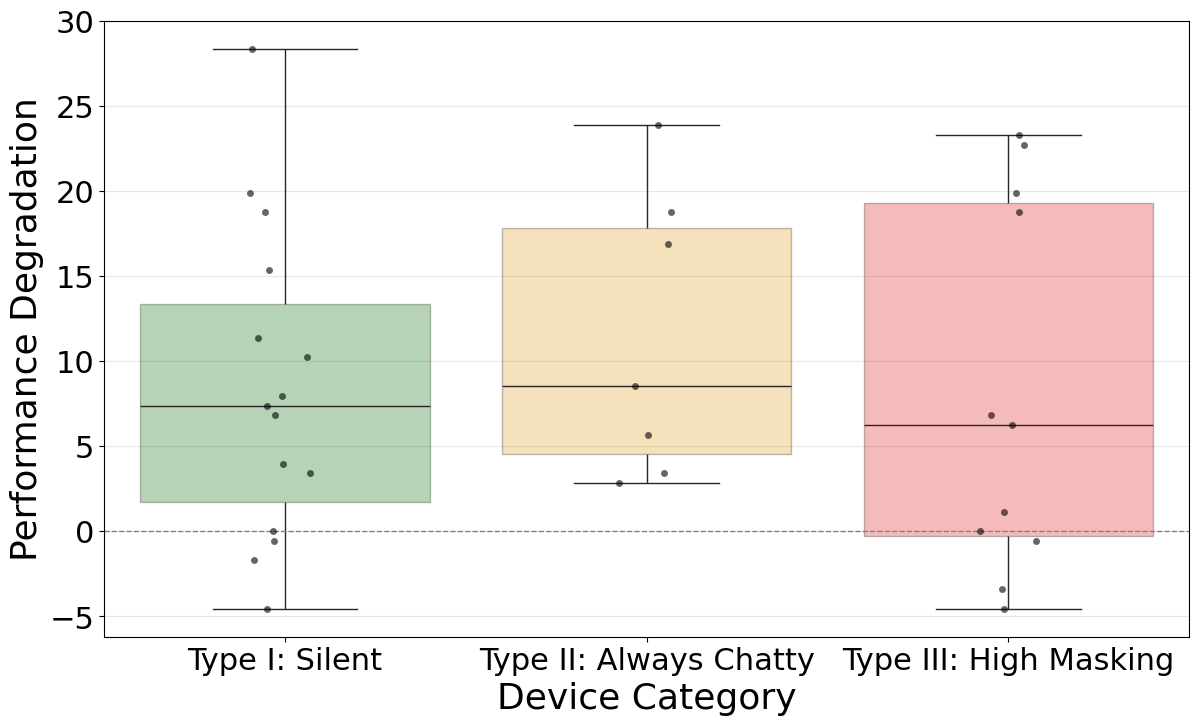

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Step 1: Generate the Statistics Table ---
# Augmenting the previous aggregation to include Idle/Active means and stds
# Note: Ensure your dataframe uses 'IDLE' and 'ACTIVE' for the F1 columns
# If they are named 'f1_idle', change accordingly.

summary_table = df.groupby('category_label').agg({
    'device': 'count',
    'f1_idle': ['mean', 'std'],      # Baseline Performance
    'f1_active': ['mean', 'std'],    # Masked Performance
    'Difference': 'mean',         # The Drop
    'pps_active': 'mean'          # The Cause
}).reset_index()

# Flatten the MultiIndex columns created by the aggregation
summary_table.columns = [
    'Category', 'N', 
    'Idle F1 Mean', 'Idle F1 Std', 
    'Active F1 Mean', 'Active F1 Std', 
    'Avg F1 Drop', 'Avg Active PPS'
]

print("=== RQ2/RQ3 DETAILED STATISTICS ===")
print(summary_table.round(2))


# --- Step 2: The Boxplot Visualization ---
plt.figure(figsize=(14, 8))

# Define the order and colors to match your previous chart
order = ["Type I: Silent", "Type II: Always Chatty", "Type III: High Masking"]
colors = {'Type I: Silent': 'green', 'Type II: Always Chatty': 'orange', 'Type III: High Masking': 'red'}

# Create the Boxplot with individual points (Strip plot) overlay
sns.boxplot(x='category_label', y='Difference', data=df, order=order, palette=colors, boxprops=dict(alpha=.3))
sns.stripplot(x='category_label', y='Difference', data=df, order=order, color='black', alpha=0.6, jitter=True)

# Add a reference line at 0 (No Masking)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Labels
# plt.title("Quantifying the Masking Effect (RQ2)", fontsize=16)
plt.xticks(rotation=0, fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel("Performance Degradation", fontsize=26)
plt.xlabel("Device Category", fontsize=26)
plt.grid(axis='y', alpha=0.3)

plt.savefig("../data/RQ2/rq2_boxplot.pdf")
plt.show()

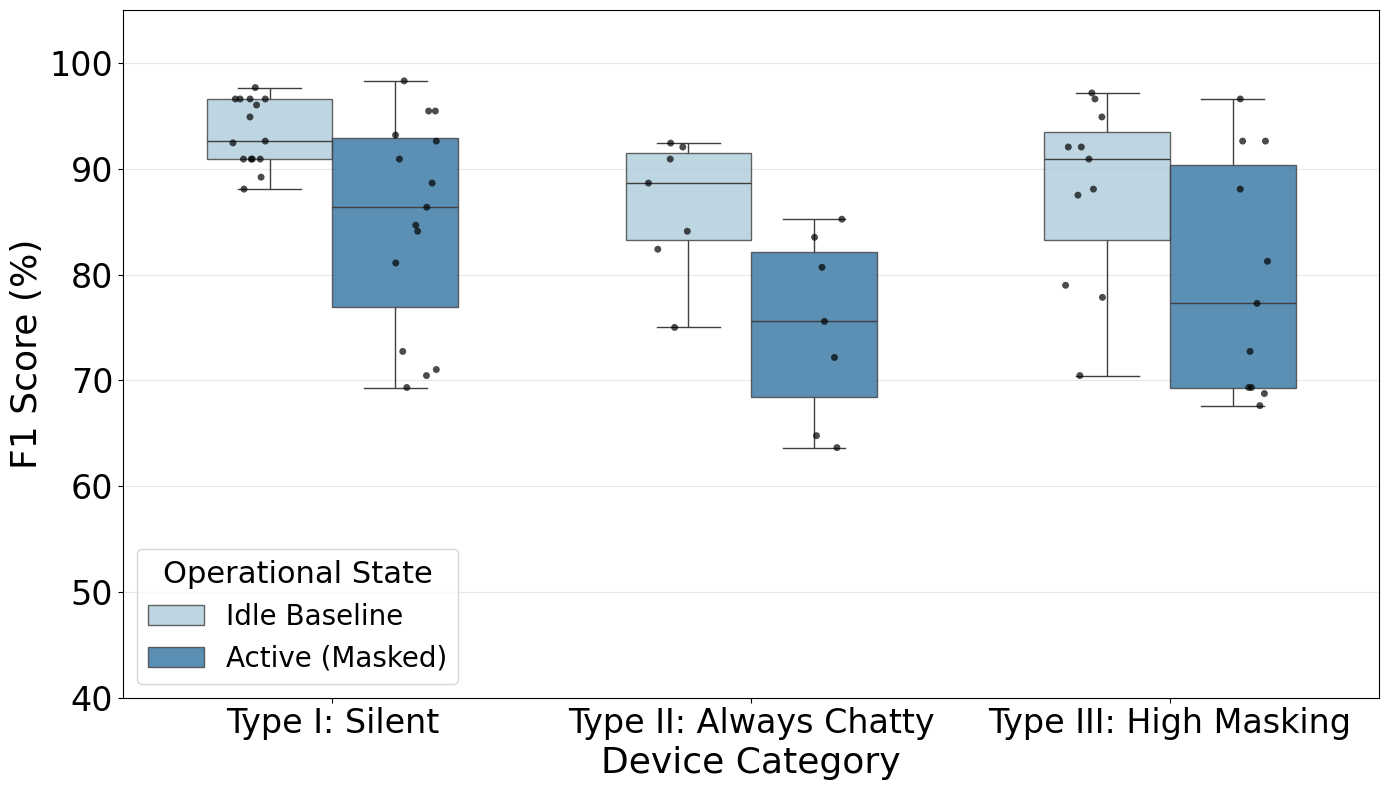

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Melt the Data to Long Format
# This creates a table like: [Device, Category, State, F1_Score]
df_long = df.melt(id_vars=['device', 'category_label'], 
                  value_vars=['f1_idle', 'f1_active'], 
                  var_name='State', 
                  value_name='F1_Score')

# Rename labels for better plotting
df_long['State'] = df_long['State'].replace({'f1_idle': 'Idle Baseline', 'f1_active': 'Active (Masked)'})

# 2. Setup the Plot
plt.figure(figsize=(14, 8))

# Define order
order = ["Type I: Silent", "Type II: Always Chatty", "Type III: High Masking"]

# Define a palette that contrasts Idle vs Active clearly
# Option A: Simple Grey vs Color
# palette = {"Idle Baseline": "lightgray", "Active (Masked)": "tab:red"}
# Option B: Distinct Blue vs Orange (Classic)
palette = {"Idle Baseline": "#a6cee3", "Active (Masked)": "#1f78b4"} 

# 3. Create the Grouped Boxplot
sns.boxplot(x='category_label', y='F1_Score', hue='State', data=df_long, 
            order=order, palette=palette, 
            boxprops=dict(alpha=0.8), width=0.6)

# Optional: Add Strip plot to show individual dots (Dodged to match boxes)
sns.stripplot(x='category_label', y='F1_Score', hue='State', data=df_long, 
              order=order, palette={'Idle Baseline': 'black', 'Active (Masked)': 'black'},
              dodge=True, jitter=True, alpha=0.7, size=5, legend=False)

# 4. Formatting
plt.ylim(40, 105) # Zoom in to relevant range
plt.ylabel("F1 Score (%)", fontsize=26)
plt.xlabel("Device Category", fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Improve Legend
plt.legend(title='Operational State', title_fontsize=22, fontsize=20, loc='lower left')
plt.grid(axis='y', alpha=0.3)

# Save and Show
plt.tight_layout()
plt.savefig("../data/RQ2/rq2_absolute_performance.pdf")
plt.show()

In [17]:
df = pd.read_csv(io.StringIO(f1_csv_data))

# 2. Categorization Logic (Matching your Lollipop Chart)
# Type III: TVs and Cameras
type_3 = ['samsungtvsmall', 'google1d15', 'toshiba', 'tclroku', 'amcrest266e', 
          'bluram6da9', 'eufy133a', 'samsungtv', 'boifun80c0', 'LGtv', 'hualai', 'yibefb']

# Type II: Smart Speakers
type_2 = ['echodot5', 'echodot3', 'echospot', 'googlehome', 'nestmini2', 'bose', 'sonos', 'homepod']

# Type I: The rest (Plugs, Bulbs, Appliances)
def get_category(dev):
    if dev in type_3: return "Type III: High Masking"
    if dev in type_2: return "Type II: Always Chatty"
    return "Type I: Silent"

df['Category'] = df['device'].apply(get_category)

# 3. Calculate Mean and Std
stats = df.groupby('Category')[['f1_idle', 'f1_active']].agg(['mean', 'std'])

print(stats.round(2))

NameError: name 'io' is not defined

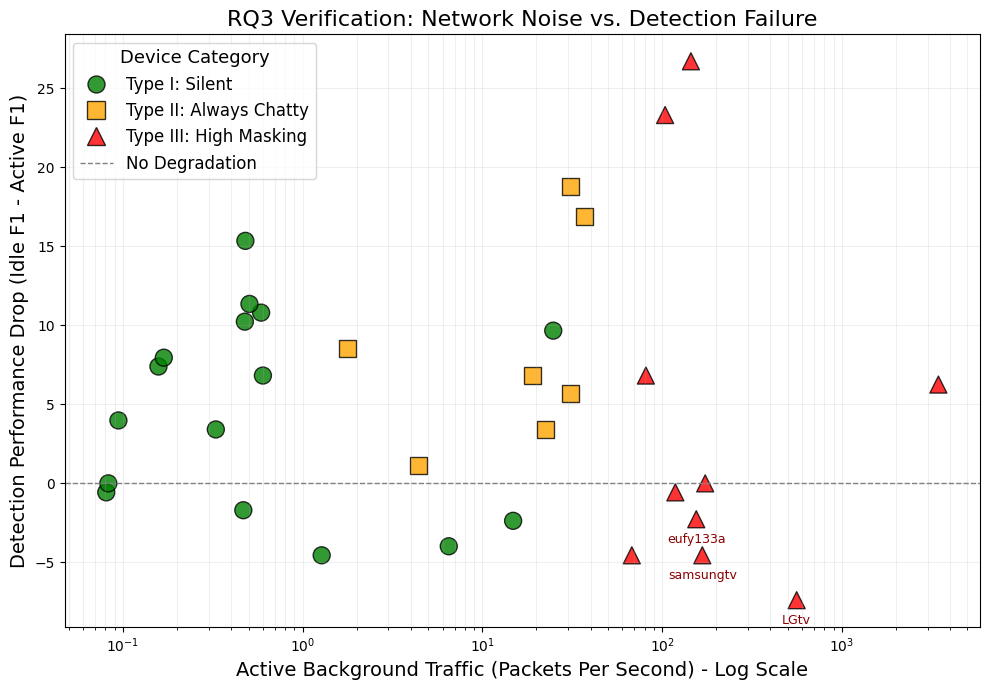

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup the figure
plt.figure(figsize=(10, 7))

# Define colors/markers to match your previous charts for consistency
palette = {'Type I: Silent': 'green', 'Type II: Always Chatty': 'orange', 'Type III: High Masking': 'red'}
markers = {'Type I: Silent': 'o', 'Type II: Always Chatty': 's', 'Type III: High Masking': '^'}

# 1. The Scatter Plot
sns.scatterplot(
    data=df, 
    x='pps_active', 
    y='Difference', 
    hue='category_label', 
    style='category_label',
    palette=palette,
    markers=markers,
    s=150, # Size of dots
    alpha=0.8,
    edgecolor='black'
)

# 2. Add Reference Lines
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='No Degradation')

# 3. Formatting
plt.xscale('log')  # Log scale is crucial because PPS ranges from 0.1 to 1000
plt.grid(True, which="both", ls="-", alpha=0.2)

# Labels
plt.xlabel("Active Background Traffic (Packets Per Second) - Log Scale", fontsize=14)
plt.ylabel("Detection Performance Drop (Idle F1 - Active F1)", fontsize=14)
plt.title("RQ3 Verification: Network Noise vs. Detection Failure", fontsize=16)

# Improve Legend
plt.legend(title='Device Category', fontsize=12, title_fontsize=13, loc='upper left')

# 4. Optional: Annotate the "Broken Baseline" devices (Negative Drop)
# This highlights the devices that failed RQ1 so bad they couldn't fail RQ2
for i, row in df.iterrows():
    if row['Difference'] < -2 and row['pps_active'] > 100:
        plt.text(row['pps_active'], row['Difference']-1.5, row['device'], 
                 fontsize=9, ha='center', color='darkred')

plt.tight_layout()
plt.show()